# Lane Detection project

In [8]:
__author__ = 'Tilak'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import imageio
from moviepy.editor import VideoFileClip
#Python OS File/Directory Methods
import os


Define program variables

In [9]:
TRACK_LEFT_SLOPE = 0
TRACK_RIGHT_SLOPE = 0
TRACK_LEFT = [0, 0, 0]
TRACK_RIGHT = [0, 0, 0]

Clear global variables before using new outputs

In [14]:
def reset_globals():
    global TRACK_LEFT_SLOPE
    global TRACK_RIGHT_SLOPE
    global TRACK_LEFT
    global TRACK_RIGHT
    TRACK_LEFT_SLOPE = 0
    TRACK_RIGHT_SLOPE = 0
    TRACK_LEFT = [0, 0, 0]
    TRACK_RIGHT = [0, 0, 0]



    This function draws lines with read color and thickness.
    It will look at the Hough lines, filter them and then assign them to left or right line.
    I also use global variables to smooth the jitter from frame to frame.
    

In [44]:
    def draw_lines(img, lines, color=[255, 0, 0], thickness=14):
        global TRACK_LEFT_SLOPE
        global TRACK_RIGHT_SLOPE
        global TRACK_LEFT
        global TRACK_RIGHT

        # DECLARE VARIABLES
        track_weight = 0.9

        right_ys = []
        right_xs = []
        right_slopes = []

        left_ys = []
        left_xs = []
        left_slopes = []

        midpoint = img.shape[1] / 2
        bottom_of_image = img.shape[0]

        for line in lines:
            for x1,y1,x2,y2 in line:
                slope, yint = np.polyfit((x1, x2), (y1, y2), 1)
                # Filter lines using slope and x position
                if .35 < np.absolute(slope) <= .85:
                    if slope > 0 and x1 > midpoint and x2 > midpoint:
                        right_ys.append(y1)
                        right_ys.append(y2)
                        right_xs.append(x1)
                        right_xs.append(x2)
                        right_slopes.append(slope)
                    elif slope < 0 and x1 < midpoint and x2 < midpoint:
                        left_ys.append(y1)
                        left_ys.append(y2)
                        left_xs.append(x1)
                        left_xs.append(x2)
                        left_slopes.append(slope)

        # DRAW RIGHT LANE LINE
        if right_ys:
            right_index = right_ys.index(min(right_ys))
            right_x1 = right_xs[right_index]
            right_y1 = right_ys[right_index]
            right_slope = np.median(right_slopes)
            if TRACK_RIGHT_SLOPE != 0:
                right_slope = right_slope + (TRACK_RIGHT_SLOPE - right_slope) * track_weight

            right_x2 = int(right_x1 + (bottom_of_image - right_y1) / right_slope)

            if TRACK_RIGHT_SLOPE != 0:
                right_x1 = int(right_x1 + (TRACK_RIGHT[0] - right_x1) * track_weight)
                right_y1 = int(right_y1 + (TRACK_RIGHT[1] - right_y1) * track_weight)
                right_x2 = int(right_x2 + (TRACK_RIGHT[2] - right_x2) * track_weight)

            TRACK_RIGHT_SLOPE = right_slope
            TRACK_RIGHT = [right_x1, right_y1, right_x2]

            cv2.line(img, (right_x1, right_y1), (right_x2, bottom_of_image), color, thickness)

        # DRAW LEFT LANE LINE
        if left_ys:
            left_index = left_ys.index(min(left_ys))
            left_x1 = left_xs[left_index]
            left_y1 = left_ys[left_index]
            left_slope = np.median(left_slopes)
            if TRACK_LEFT_SLOPE != 0:
                left_slope = left_slope + (TRACK_LEFT_SLOPE - left_slope) * track_weight

            left_x2 = int(left_x1 + (bottom_of_image - left_y1) / left_slope)

            if TRACK_LEFT_SLOPE != 0:
                left_x1 = int(left_x1 + (TRACK_LEFT[0] - left_x1) * track_weight)
                left_y1 = int(left_y1 + (TRACK_LEFT[1] - left_y1) * track_weight)
                left_x2 = int(left_x2 + (TRACK_LEFT[2] - left_x2) * track_weight)

            TRACK_LEFT_SLOPE = left_slope
            TRACK_LEFT = [left_x1, left_y1, left_x2]

            cv2.line(img, (left_x1, left_y1), (left_x2, bottom_of_image), color, thickness)



    Takes in an image and uses Canny Edge Detection and Hough Transformations
    to detect lines in the image and then draw the lane lines onto the original
    image.

In [27]:
def process_image(image):

    # PARAMETERS
    imshape = image.shape
    kernel_size = 3
    sigma_x = 0
    low_canny_threshold = 25
    high_canny_threshold = low_canny_threshold * 3
    vertices = np.array([[(0,imshape[0]), (9*imshape[1]/20, 11*imshape[0]/18), (11*imshape[1]/20, 11*imshape[0]/18), (imshape[1],imshape[0])]], dtype=np.int32)
    ignore_mask_color = 255
    rho = 1
    theta = np.pi/180
    hough_threshold = 10
    min_line_len = 30
    max_line_gap = 60
    α = 0.8
    β = 1.
    λ = 0.

    # GRAYSCALE
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # GAUSSIAN BLUR
    blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), sigma_x)

    # CANNY EDGES
    edges = cv2.Canny(blur, low_canny_threshold, high_canny_threshold)

    # REGION MASK
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(edges, mask)

    # HOUGH TRANSFORM
    lines = cv2.HoughLinesP(masked, rho, theta, hough_threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    hough_image = np.zeros((*masked.shape, 3), dtype=np.uint8)
    draw_lines(hough_image, lines)

    # WEIGHTED IMAGE
    processed = cv2.addWeighted(image, α, hough_image, β, λ)

    return processed


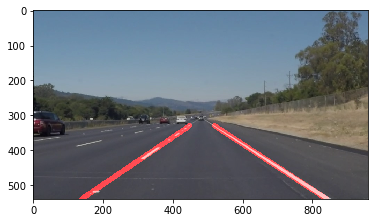

In [29]:
# TEST IMAGE
image = mpimg.imread("/Users/Tilak/PycharmProjects/python36/test_images/solidWhiteRight.jpg")
plt.imshow(process_image(image))
plt.show()

In [ ]:
 SAVE PROCESSED IMAGES TO ./final_images

In [39]:
imageNames = os.listdir('/Users/Tilak/PycharmProjects/python36/test_images/')
for name in imageNames:
    reset_globals()
    image = mpimg.imread("/Users/Tilak/PycharmProjects/python36/test_images/{}".format(name))
    plt.imsave("/Users/Tilak/PycharmProjects/python36/final_images/final_{}".format(name), process_image(image))

In [42]:
# CREATE VIDEO THAT DRAWS LANE LINES ON solidWhiteRight.mp4
reset_globals()
white_output = '/Users/Tilak/PycharmProjects/python36/TRACKwhite.mp4'
clip1 = VideoFileClip("/Users/Tilak/PycharmProjects/python36/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video /Users/Tilak/PycharmProjects/python36/TRACKwhite.mp4
[MoviePy] Writing video /Users/Tilak/PycharmProjects/python36/TRACKwhite.mp4


100%|█████████▉| 221/222 [00:05<00:00, 42.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/Tilak/PycharmProjects/python36/TRACKwhite.mp4 



In [36]:
# CREATE VIDEO THAT DRAWS LANE LINES ON solidYellowLeft.mp4
reset_globals()
yellow_output = '/Users/Tilak/PycharmProjects/python36/TRACKyellow.mp4'
clip1 = VideoFileClip("/Users/Tilak/PycharmProjects/python36/solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image)
yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video /Users/Tilak/PycharmProjects/python36/TRACKyellow.mp4
[MoviePy] Writing video /Users/Tilak/PycharmProjects/python36/TRACKyellow.mp4


100%|█████████▉| 681/682 [00:18<00:00, 37.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/Tilak/PycharmProjects/python36/TRACKyellow.mp4 



In [37]:
# CREATE VIDEO THAT DRAWS LANE LINES ON challenge.mp4
reset_globals()
challenge_output = '/Users/Tilak/PycharmProjects/python36/FinalResult.mp4'
clip2 = VideoFileClip('/Users/Tilak/PycharmProjects/python36/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video /Users/Tilak/PycharmProjects/python36/FinalResult.mp4
[MoviePy] Writing video /Users/Tilak/PycharmProjects/python36/FinalResult.mp4


100%|██████████| 251/251 [00:24<00:00, 10.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/Tilak/PycharmProjects/python36/FinalResult.mp4 



Done!